# Emergency vs non-emergency audio classification
**Goal:**</br>
To classify audio of an emergency vehicle from a non-emergency vehicle using deep learning techniques.

**Business problem:**<br>
~20K people die daily due to delays on medical assistance. Hence, traffic signals coud be modify based on audio signals to reduce the dealays on these kind of attentions.

In [1]:
#!pip install librosa

In [2]:
import librosa
import scipy
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import sys
sys.path.append('..')

from utils.s3_class import S3Functions
s3_funcs = S3Functions(bucket_name='jdgallegoq-pinacle')

In [4]:
# load audio and sample rate
emergency, sample_rate = librosa.load(
    s3_funcs.read_audio('emergencyvh-audio-clf/emergency.wav'),
    sr=16000
)
non_emergency, sample_rate = librosa.load(
    s3_funcs.read_audio('emergencyvh-audio-clf/non emergency.wav'),
    sr=16000
)

In [5]:
# see audio durations
duration1 = librosa.get_duration(y=np.array(emergency), sr=16000)
duration2 = librosa.get_duration(y=np.array(non_emergency), sr=16000)

duration1/60, duration2/60

(22.920290625, 27.160834375)

In [6]:
# prepare the data
# split the audio in chunks of n seconds
# for this exercise, let's work with 2seg chunks
def prepare_audio(audio_data, num_samples:int=None, sr:int=None):
    data = []
    for offset in range(0, len(audio_data), sr):
        start = offset
        end = offset + num_samples
        chunk = audio_data[start:end]

        if len(chunk)==num_samples:
            data.append(chunk)
    
    return data

In [7]:
emergency_pp = prepare_audio(emergency, num_samples=32000, sr=16000)
non_emergency_pp = prepare_audio(non_emergency, num_samples=32000, sr=16000)

len(emergency_pp), len(non_emergency_pp)

(1374, 1628)

In [8]:
# listen the clips
ipd.Audio(emergency_pp[136], rate=16000)

In [9]:
# listen the clips
ipd.Audio(non_emergency_pp[136], rate=16000)

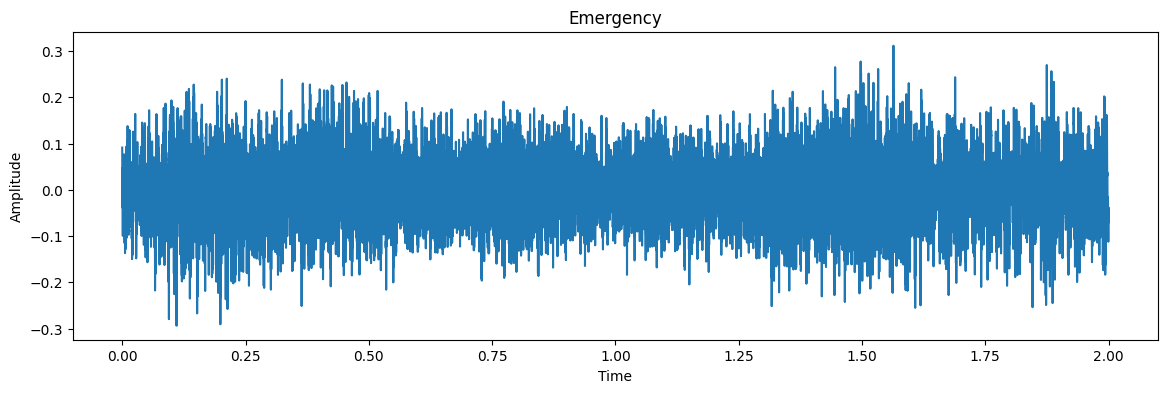

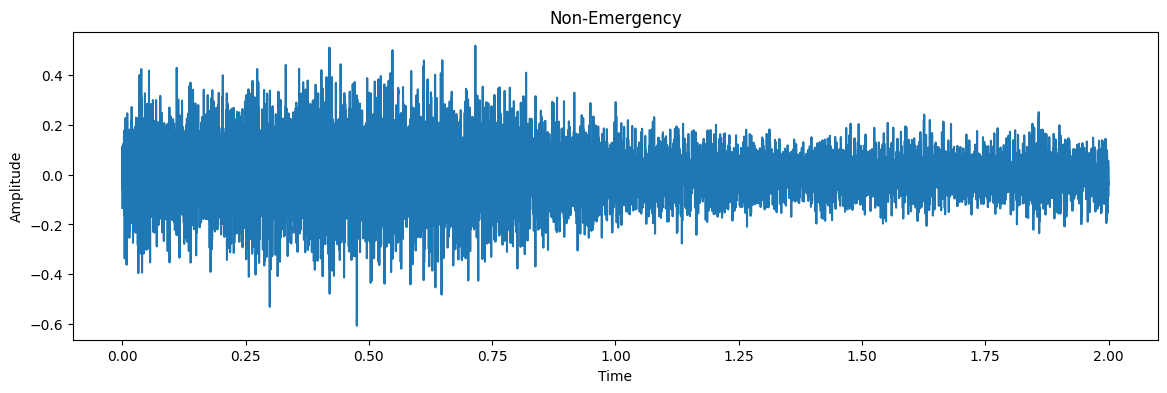

In [10]:
# visualization of audio data
plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, 2, num=32000), emergency_pp[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

# visualization of audio data
plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, 2, num=32000), non_emergency_pp[103])
plt.title('Non-Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [11]:
# combine audio chunks for splitting train a test data
audio = np.concatenate([emergency_pp, non_emergency_pp])

# assign labels
labels1 = np.zeros(len(emergency_pp))
labels2 = np.zeros(len(non_emergency_pp))

# concatenate labels
labels = np.concatenate([labels1, labels2])

In [12]:
# see shapes
audio.shape, labels.shape

((3002, 32000), (3002,))

In [13]:
from sklearn.model_selection import train_test_split

# split
X_train, X_val, y_train, y_val = train_test_split(
    np.array(audio),
    np.array(labels),
    stratify=labels,
    test_size=0.1,
    random_state=42,
    shuffle=True
)

In [14]:
# need to make it 3d
x_train_features = X_train.reshape(len(X_train), -1, 1)
x_val_features = X_val.reshape(len(X_val), -1, 1)

In [15]:
from keras.layers import (
    Input,
    Conv1D,
    Dropout,
    MaxPooling1D,
    GlobalMaxPool1D,
    Dense
)
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [16]:
# model architecture
def conv_model(x_train):
    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))
    # first conv layer
    conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
    conv = Dropout(0.3)(conv)
    conv = MaxPooling1D(2)(conv)
    # second conv layer
    conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
    conv = Dropout(0.3)(conv)
    conv = MaxPooling1D(2)(conv)
    # Global max pooling
    conv = GlobalMaxPool1D()(conv)
    # Dense layer
    conv = Dense(16, activation='relu')(conv)
    outputs = Dense(1, activation='sigmoid')(conv)
    # define model
    model = Model(inputs, outputs)
    # compile
    model.compile(
        loss='binary_crossentropy',
        optimizer='Adam',
        metrics=['acc']
    )
    # define callbacks
    model_checkpoint = ModelCheckpoint(
        '../module/models/best_model.hdf5',
        monitor='val_loss',
        verbose=3,
        save_best_only=True,
        mode='min'
    )

    return model, model_checkpoint


In [17]:
model, model_checkpoint = conv_model(x_train_features)

In [18]:
# train
history = model.fit(
    x_train_features,
    y_train,
    epochs=10,
    callbacks=[model_checkpoint],
    batch_size=32,
    validation_data=(x_val_features, y_val)
)

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.1424 - acc: 1.0000
Epoch 1: val_loss improved from inf to 0.04645, saving model to ../module/models/best_model.hdf5
85/85 [==============================] - 9s 39ms/step - loss: 0.1424 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 1.0000
Epoch 2/10
83/85 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 1.0000
Epoch 2: val_loss improved from 0.04645 to 0.01951, saving model to ../module/models/best_model.hdf5
85/85 [==============================] - 3s 35ms/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 3/10
83/85 [============================>.] - ETA: 0s - loss: 8.9657e-04 - acc: 1.0000
Epoch 3: val_loss improved from 0.01951 to 0.01180, saving model to ../module/models/best_model.hdf5
85/85 [==============================] - 3s 35ms/step - loss: 8.9682e-04 - acc: 1.0000 - val_loss: 0.0118 - val_acc: 1.0000
Epoch 4/10
83/85 [============================>.] - ETA: 0s - loss

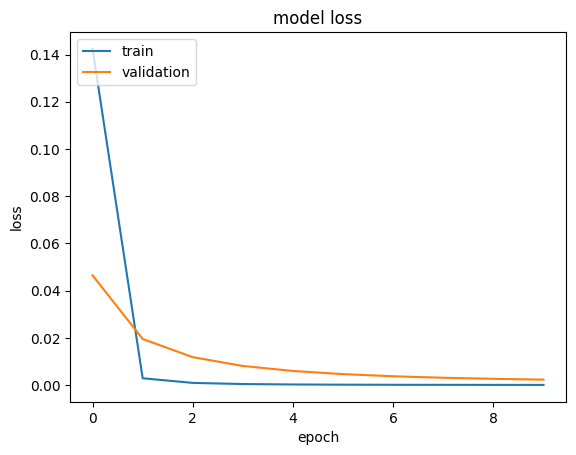

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='upper left')
plt.show()

In [23]:
# let's inference using the model
ind = 35
test_audio = X_val[ind]
ipd.Audio(test_audio, rate=16000)

In [24]:
# classify
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1, -1, 1))
if (prob[0][0]<0.5):
    print('Emegency')
else:
    print('non-emergency')

1/1 [==============================] - 0s 35ms/step
Emegency


In [25]:
# using spectrogram features
# need to take care of teo new concepts:
# 1. nperseg: number of samples in each chunk
# 2. noverlap: number of overlapping samples between each window

In [26]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg = 320
    noverlap = 160

    freqs, times, spec = scipy.signal.spectrogram(
        audio,
        fs=sample_rate,
        nperseg=nperseg,
        noverlap=noverlap
    )
    return freqs, times, np.log(spec.T.astype(np.float32)+eps)

In [27]:
def plot_specgram(specgram, label):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(211)
    ax.imshow(
        specgram.T,
        aspect='auto',
        extent=[
            times.min(),
            times.max(),
            freqs.min(),
            freqs.max()
        ]
    )
    ax.set_title('Spectogram of ' + label)
    ax.set_ylabel('Freqs in Hz')
    ax.set_xlabel('Seconds')

In [29]:
emergency[300]

0.0

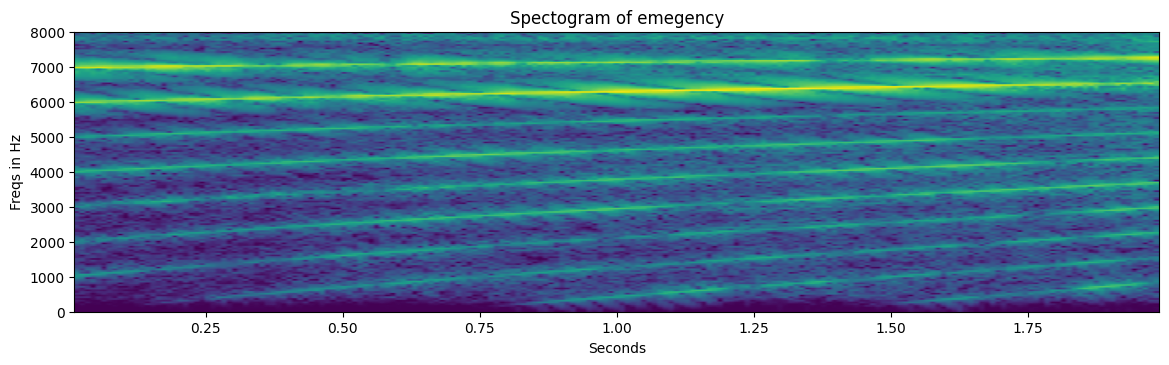

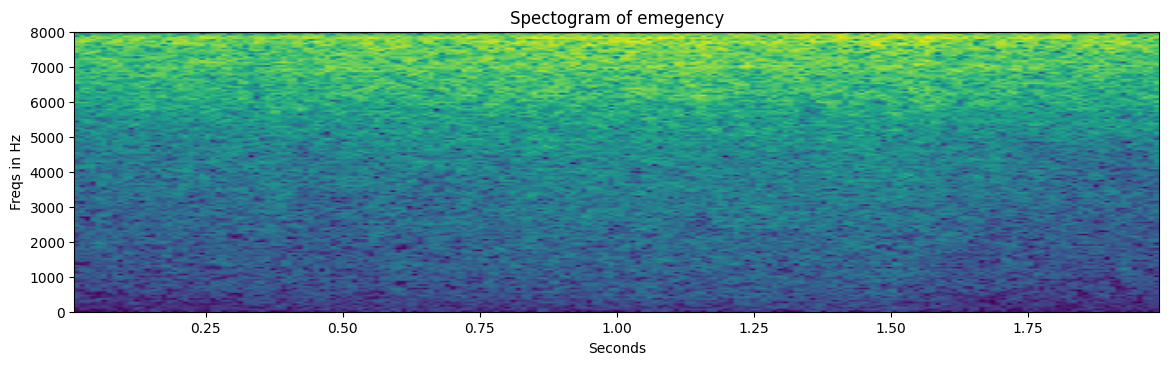

In [31]:
freqs, times, specgram = log_specgram(emergency_pp[300], sample_rate)
plot_specgram(specgram, label='emegency')
freqs, times, specgram = log_specgram(non_emergency_pp[300], sample_rate)
plot_specgram(specgram, label='emegency')